In [344]:
import numpy as np
from simulation.generate_path import generate_path
import matplotlib.pyplot as plt
from estimation.distance_sensor import distance_sensors
import random
import torch
import torch.nn as nn
import time

In [345]:
# create test data
target_initial_pos = np.array([0, 0, 5000])
target_speed_xy = 50
target_speed_z = 10
target_rot_speed = 3
time_res = 0.5

path1 = generate_path(0, target_speed_xy, target_speed_z, target_initial_pos, time_res)
path1.add_straight_interval(100)
path1.add_xy_turn_interval(90, -np.deg2rad(target_rot_speed))
path1.add_straight_interval(100)

# create noisy sensors
sensors = distance_sensors([[-5000,0,0],[ 400, -7400, 0],[ 800, 800, 0]], 15)
sensors.calculate_measurements(path1.path)

sample = 3
XTest = []
for i in np.arange(len(path1.path) - sample + 1):
    tmp = np.concatenate((sensors.sensor_locations, np.reshape(sensors.noisy_distances[i,:], (1,3))), 0)
    tmp = tmp.reshape(4,3,1)
    for j in np.arange(1,sample):
        matrix = np.concatenate((sensors.sensor_locations, np.reshape(sensors.noisy_distances[i+j,:], (1,3))), 0)
        matrix = matrix.reshape(4,3,1)
        tmp = np.concatenate((tmp, matrix),axis=2)
    if i > 0:
        tmp = tmp.reshape(4,3,sample,1)
        XTest = np.concatenate((XTest, tmp), 3)
    else:
        tmp = tmp.reshape(4,3,sample,1)
        XTest = tmp

YTest = path1.state_key[sample-1:]

print(np.shape(YTest))
print(np.shape(XTest))

(576, 1)
(4, 3, 3, 576)


In [346]:
# create train data
run_number = 2000
for k in np.arange(run_number):
    target_initial_pos = np.random.randint(-7000, 7000, size=(1, 3))[0]
    sensors_pos = np.random.randint(-7000, 7000, size=(3, 3))[:,:]
    target_speed_xy = 50
    target_speed_z = 10
    target_rot_speed = 3
    time_res = 0.5

    path1 = generate_path(0, target_speed_xy, target_speed_z, target_initial_pos, time_res)
    path1.add_straight_interval(np.random.randint(0,100,size=1)[0])
    path1.add_xy_turn_interval(np.random.randint(0,100,size=1)[0], -random.choice([-1, 1])*np.deg2rad(target_rot_speed))

    # create noisy sensors
    sensors = distance_sensors(sensors_pos, 15)
    sensors.calculate_measurements(path1.path)

    sample = 3
    XTrain = []
    for i in np.arange(len(path1.path) - sample + 1):
        tmp = np.concatenate((sensors.sensor_locations, np.reshape(sensors.noisy_distances[i,:], (1,3))), 0)
        tmp = tmp.reshape(4,3,1)
        for j in np.arange(1,sample):
            matrix = np.concatenate((sensors.sensor_locations, np.reshape(sensors.noisy_distances[i+j,:], (1,3))), 0)
            matrix = matrix.reshape(4,3,1)
            tmp = np.concatenate((tmp, matrix),axis=2)
        if i > 0:
            tmp = tmp.reshape(4,3,sample,1)
            XTrain = np.concatenate((XTrain, tmp), 3)
        else:
            tmp = tmp.reshape(4,3,sample,1)
            XTrain = tmp

    YTrain = path1.state_key[sample-1:]

print(np.shape(YTrain))
print(np.shape(XTrain))


(127, 1)
(4, 3, 3, 127)


In [347]:
# shuffle data
ind = np.arange(len(YTest))
random.shuffle(ind)

XVal = torch.from_numpy(np.transpose(XTest, (3, 2, 0, 1)))
YVal = torch.from_numpy(YTest)

XTrain = torch.from_numpy(np.transpose(XTest[:,:,:,ind], (3, 2, 0, 1)))
YTrain = torch.from_numpy(YTest[ind,:])

In [348]:
# create network
class state_estimat(nn.Module):
    def __init__(self, d_in, num_classes):
        # initialzing the parent object (important!)
        super(state_estimat, self).__init__()
        # Create a pipeline - a sequence of layers
        self.pipe = torch.nn.Sequential(
            nn.Conv2d(d_in, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32*3*4, num_classes),
            nn.Sigmoid())

    def forward(self, x):
        return self.pipe(x)


In [349]:
# hyper-parameters:
num_epochs = 20
batch_size = 128
learning_rate = 0.0001
learning_rate_drop_period = 4
input_shape = [3,4,3]

# Device configuration, as before
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# create model
model = state_estimat(d_in=3, num_classes=1).to(device)
print(model)
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=learning_rate_drop_period, gamma=0.1)

state_estimat(
  (pipe): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=384, out_features=1, bias=True)
    (8): Sigmoid()
  )
)


In [350]:
# Train the model
total_step = len(YTrain)
start_time = time.time()
model = model.float()

loss_train = []
loss_val = []
loss_tmp = 0
norm = 10
for i in range(len(YVal)):
        # each i is a batch of 128 samples
        x, y = XVal[i,:,:,:], YVal[i,:]

        x = x.unsqueeze(0).to(device)
        y = y.unsqueeze(0).to(device)

        # Forward pass val
        outputs = model(x.float())
        loss = criterion(norm*outputs, norm*y.float().T)
        loss_tmp += loss.item()
loss_val.append(loss_tmp/len(YVal))

for epoch in range(num_epochs):
    ind = np.arange(int(total_step/batch_size))
    random.shuffle(ind)
    for i in ind:
        # each i is a batch of 128 samples
        x, y = XTrain[i*batch_size:(i+1)*batch_size,:,:,:], YTrain[i*batch_size:(i+1)*batch_size,:]

        x = x.to(device)
        y = y.to(device)

        # Forward pass
        outputs = model(x.float())
        loss = criterion(norm*y.float().T, norm*outputs)
        # loss = norm*outputs - norm*y.float().T

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_train.append(loss.item())

        if (i + 1) % 10 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Time: {:.4f} secs'
                    .format(epoch + 1, num_epochs, i + 1, int(total_step/batch_size), loss.item(), time.time() - start_time))

    loss_tmp = 0
    for i in range(len(YVal)):
        # each i is a batch of 128 samples
        x, y = XVal[i,:,:,:], YVal[i,:]

        x = x.unsqueeze(0).to(device)
        y = y.unsqueeze(0).to(device)

        # Forward pass val
        outputs = model(x.float())
        loss = criterion(norm*outputs, norm*y.float().T)
        loss_tmp += loss.item()

    loss_val.append(loss_tmp/len(YVal))

    scheduler.step()

D:\technion\סמסטר 9 אביב 2023\ProjectB\python\venv\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([1, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


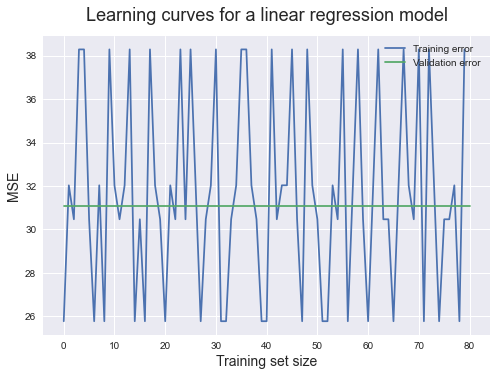

In [351]:
plt.style.use('seaborn')
plt.plot(np.arange(len(loss_train)), loss_train, label = 'Training error')
plt.plot(np.arange(0, len(loss_train)+1, int(total_step/batch_size)), loss_val, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
plt.legend()